In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from src.utils import data
from src.utils import ucr_2018
import seaborn as sns
mpl.rcParams.update({"figure.facecolor": "white"})

In [38]:
train_df, test_df = ucr_2018.get_dataset("ECG5000")
X_train, y_train = data.x_y_split(train_df, y_col=0)
X_test, y_test = data.x_y_split(test_df, y_col=0)

In [39]:
print("%d train records, %d test records" % (train_df.shape[0], test_df.shape[0]))
print(train_df.groupby(0).count()[1].to_dict())
print(test_df.groupby(0).count()[1].to_dict())

500 train records, 4500 test records
{1: 292, 2: 177, 3: 10, 4: 19, 5: 2}
{1: 2627, 2: 1590, 3: 86, 4: 175, 5: 22}


### Przykładowe rekordy

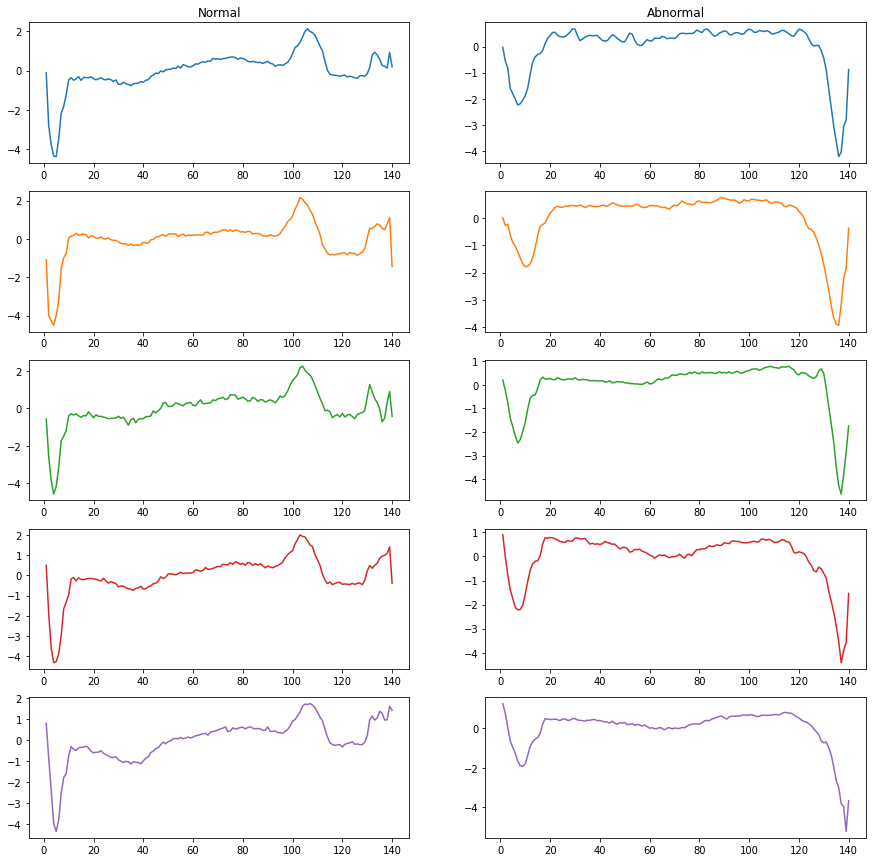

In [40]:
fig, axs = plt.subplots(5, 2, figsize=(15,15))
train_df[train_df[0]==1].drop(columns=[0]).head().T\
    .plot(ax=axs[:, 0], subplots=True, legend=False)
train_df[train_df[0]!=1].drop(columns=[0]).head().T\
    .plot(ax=axs[:, 1], subplots=True, legend=False)
axs[0, 0].set_title("Normal")
axs[0, 1].set_title("Abnormal");

### Czy rekordy tworzą razem jedną spójną serię czasową?

In [17]:
start = 0

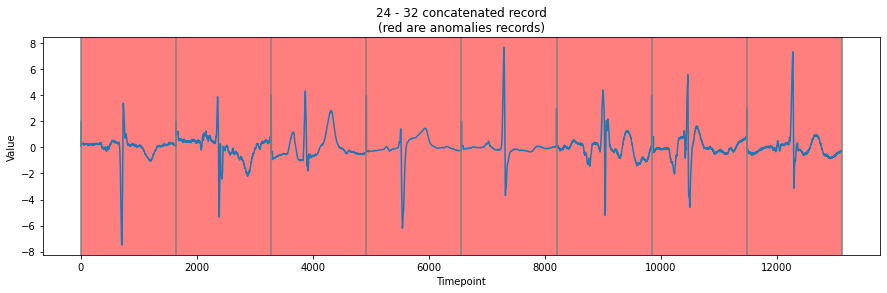

In [21]:
rec_len = train_df.shape[1]
n_first_rec = start + 8
ax = pd.concat([train_df.iloc[i] for i in train_df.index[start:n_first_rec]], ignore_index=True)\
    .plot(figsize=(15, 4))
for i in range(n_first_rec - start + 1):
    plt.axvline(i * rec_len, c="gray")
for i in train_df.iloc[start:n_first_rec].loc[train_df[0]!=1].index:
    plt.axvspan((i-start) * rec_len, (i-start+1) * rec_len, facecolor='r', alpha=0.5)
ax.set(
    xlabel ='Timepoint',
    ylabel ='Value',
    title="%d - %d concatenated record\n(red are anomalies records)" % (start, n_first_rec)
);
start = start + 8

Obserwując na niektórych granicach serii czasowych skoki, można dojść do wniosku, że nie tworzą jednej serii czasowej. Mają za to podobne charakterystyki.

# Badanie charakterystyk

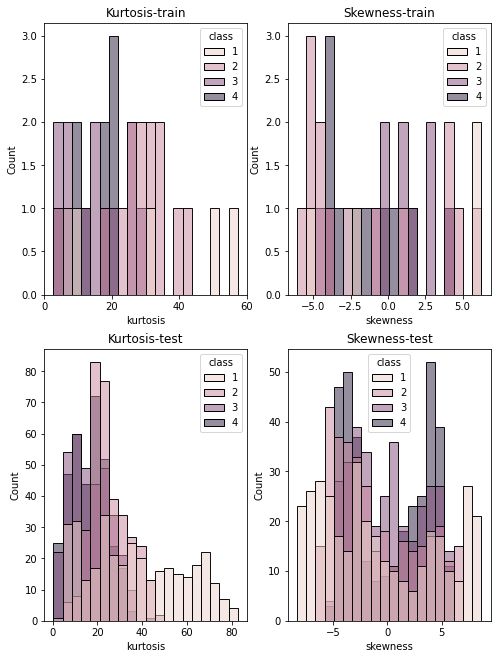

In [28]:
df = pd.DataFrame(data={
    "kurtosis": X_train.kurt(axis=1),
    "skewness": X_train.skew(axis=1),
    "class": y_train
})
fig, axs = plt.subplots(2, 2, figsize=(8, 11))
sns.histplot(
    data=df,
    x="kurtosis",
    hue="class",
    bins=20,
    ax=axs[0, 0]
).set_title("Kurtosis-train")
sns.histplot(
    data=df,
    x="skewness",
    hue="class",
    bins=20,
    ax=axs[0, 1]
).set_title("Skewness-train");

df = pd.DataFrame(data={
    "kurtosis": X_test.kurt(axis=1),
    "skewness": X_test.skew(axis=1),
    "class": y_test
})
sns.histplot(
    data=df,
    x="kurtosis",
    hue="class",
    bins=20,
    ax=axs[1, 0]
).set_title("Kurtosis-test")
sns.histplot(
    data=df,
    x="skewness",
    hue="class",
    bins=20,
    ax=axs[1, 1]
).set_title("Skewness-test");

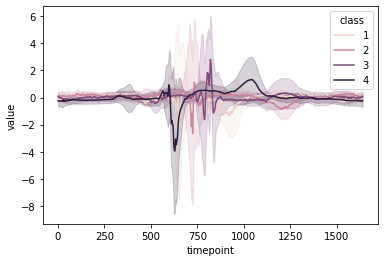

In [30]:
from numpy import median
df = X_train.stack().reset_index().rename(
    columns={
        "level_0": "record_id",
        "level_1": "timepoint",
        0: "value"
    }
)
df["class"] = df.apply(lambda x: y_train[x["record_id"]], axis=1)
sns.lineplot(
    data=df, 
    x="timepoint", 
    y="value", 
    hue="class",
    estimator=median,
    ci="sd" # ci - confidence intervals, sd - standard deviation
);